In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from IPython.display import clear_output
import time

import gymnasium as gym
from gymnasium import spaces
import pprint

import copy


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

The game is a simpler version of the TtR base game. It has 3 cities and 3 routes connecting them, with route lengths of 1 and 2 wagons. There are only 2 colors, red and grey. And only 1 ticket. The card draw is simplified, drawing a card gives you the first card of the deck. The game ends when one player claims the single route.

In [ ]:
def simple_game_set_up_tm():
## SET UP THE GAME:
# 1. define board_active (routes, cities, standard color)
# and board_static stats (tickets, player order, current player, turn count, train card deck and discard pile)
# 2. Shuffle and create the train card deck
# 3. Set up player dict (train cards in hand, score, remaining trains, claimed routes, ticket in hand, completed tickets

  board_static = {

      "routes": {
          'VAN_SEA_1_grey': {'city_1_id': 'VAN',
          'city_2_id': 'SEA',
          'length': 1,
          'color': 'grey',
          'owner': None},
          'VAN_SEA_1_red': {'city_1_id': 'VAN',
          'city_2_id': 'SEA',
          'length': 1,
          'color': 'red',
          'owner': None},
          'SEA_POR_2_red': {'city_1_id': 'SEA',
          'city_2_id': 'POR',
          'length': 2,
          'color': 'red',
          'owner': None}},
      "cities":[{"id": "VAN", "CName": "Vancouver", "coo": "1-11"},
                {"id": "POR", "CName": "Portland", "coo": "0-9"},
                {"id": "SEA", "CName": "Seattle", "coo": "1-10"}],
      "standard_colors": ["grey", "red"]
                }
  player_list = ["player_0", "player_1"]
  board_activ = {
      "tickets": [{'city_1_id': 'VAN', 'city_2_id': 'POR', 'points': 3},
                  ],


      'player_order': deque(player_list),
      'current_player': player_list[0],
      'turn_count': 0,
      "claimed_routes": [],

      "train_car_cards": {"grey": 20, "red": 20},
      'train_card_deck': [],
      "discard_pile_train_cards": {"grey": 0, "red": 0},
      'last_round_triggered_by': None, #

      }

  players={}


  # Shuffles and creates the train card deck.
  for color, count in board_activ['train_car_cards'].items():
    board_activ['train_card_deck'].extend([color] * count)
    random.shuffle(board_activ['train_card_deck'])



  players = {

             "player_0": {
        'train_cards_in_hand': {"grey": 0, "red": 0},

        'score': 0,
        'remaining_trains': 45,
        "routs_claimed_id": [],
        'tickets_in_hand': [{'city_1_id': 'VAN', 'city_2_id': 'POR', 'points': 3}],
        'completed_tickets': [],},


             "player_1": {
        'train_cards_in_hand': {"grey": 0, "red": 0},

        'score': 0,
        'remaining_trains': 45,
        "routs_claimed_id": [],
        'tickets_in_hand': [{'city_1_id': 'VAN', 'city_2_id': 'POR', 'points': 3}],
        'completed_tickets': [],}



  }

  #print("game set up finished")

  return board_static, board_activ, players

In [ ]:
# define a player action for the 2 main actions (1.) Draw card and (2.) Claim route
# draw ticket action is not needed in the tiny map setup of the game because there is only 1 ticket. Both players have this ticket in their hand at the start of the game
# the player action will be used for the ai agent and the ai-opponent player.

def player_action(player, players, action_type, action_details, board_static, board_activ):
  player_data = players[player]
  success = False
  reward_delta = 0
  info_string = ""

# --------------(1.) Draw card logic:-------------------
  if action_type == 'draw_card':
    #get color of drawn card
    card_color = action_details.get('color', None)


    # check if any card available in deck, move card to player hand, delete it from deck
    if board_activ['train_card_deck']:
      drawn_card = board_activ['train_card_deck'].pop(0)
      player_data['train_cards_in_hand'][drawn_card] = player_data['train_cards_in_hand'].get(drawn_card, 0) + 1


      # give reward and define info string.
      success = True
      reward_delta = 0.1
      info_string = 'draw_card'
      #print(f"{player} drew card {drawn_card}")


    # catch fail, give small penalty, define info string
    else:
      reward_delta = -0.1 # Small penalty for invalid action or no-op
      info_string = 'draw_card_failed_empty_deck'

# --------------(2.) claim_route logic:------------------

  elif action_type == 'claim_route':


    # get variables of route to claim
    route_to_claim_id = action_details['route_id']
    route_to_claim_info = board_static['routes'][route_to_claim_id]
    required_cards = route_to_claim_info['length']
    required_color = route_to_claim_info['color']
    player_required_color_cards = player_data['train_cards_in_hand'].get(required_color, 0)
    player_wagons = player_data['remaining_trains']


    # check if player has enough color cards, wagons and if the route is still unclaimed.
    if (route_to_claim_info['owner'] is None and player_required_color_cards>= required_cards and player_wagons >= required_cards):


      # change route owner, deduct cards and wagons from player, add route to players claimed route list      route_to_claim_info['owner'] = player
      player_data['remaining_trains'] -= required_cards
      player_data['score'] += route_to_claim_info['length']
      player_data['train_cards_in_hand'][required_color] -= required_cards
      board_activ['discard_pile_train_cards'][required_color] += required_cards
      player_data['routs_claimed_id'].append(route_to_claim_id)
      #print(f"{player} claimed route {route_to_claim_id}")


      #give reward and define info string.
      success = True
      reward_delta = 10 # medium reward for claiming a route
      info_string = f'claim_route_success_{route_to_claim_id}'


    # catch fail, give small penalty, define info string
    else:
      reward_delta = -1 # Penalty for failed claim
      info_string = f'claim_route_failed_{route_to_claim_id}'


  # catch invalid action, give small penalty, define info string
  else:
    reward_delta = -0.5 # Penalty for invalid action
    info_string = 'invalid_action_type'

  return success, reward_delta, info_string




In [ ]:
# simple hard coded ai-opponent: (1.) tries to claim route, (2.) If not possible, draws a card
def ai_oponent(opponent_id, players, board_static, board_activ):
  # get variables of opponent player
  opponent_data = players[opponent_id]
  all_route_ids = list(board_static['routes'].keys())
  random.shuffle(all_route_ids) # Randomize order for simple opponent
  opponent_wagons = opponent_data['remaining_trains']
  info_string = ""


  # --------------(1.) tries to claim route:------------------
  # loop through all routes, see if it's possible to claim and if so, claim it.
  for route_id in all_route_ids:
    route_info = board_static['routes'][route_id]
    required_length = route_info['length']
    required_color = route_info['color']
    opponent_required_color_cards = opponent_data['train_cards_in_hand'].get(required_color, 0)


    if route_info['owner'] is None and opponent_required_color_cards  >= required_length and opponent_wagons >= required_length:
      player_action(opponent_id, players, 'claim_route', {'route_id': route_id}, board_static, board_activ)
      info_string = f'claimed_route_{route_id}'
      return info_string


# --------------(2.) If not possible draws a card:------------------
  player_action(opponent_id, players, 'draw_card', {}, board_static, board_activ)
  info_string = 'draw_card'

  return info_string

In [ ]:
class TicketToRideEnv(gym.Env):
  def __init__(self):
    super().__init__()
    self.board_static, self.board_activ, self.players = simple_game_set_up_tm()
    self.ai_player_id = self.board_activ['player_order'][0]


    # ACTION SPACE:
    # 1. draw grey card, 2. draw red card 3.-5. claim route
    self.action_space = spaces.Discrete(5)


    # OBSERVATION SPACE
    # grey cards low 0 high 20
    # red cards low 0 high 20
    # 3 routes low -1 (opponent claimed) high 1 (own claim)
    # fulfillment status of only ticket low 0 (unclaimed) high 1 (claimed)
    self.observation_space = spaces.Box(
        low=np.array([0, 0, -1, -1,-1, 0], dtype=np.int32),
        high=np.array([20, 20, 1, 1, 1, 1], dtype=np.int32),
        shape=(6,),
        dtype=np.int32
    )

    self.current_episode = 0
    self.max_episode_steps = 30

    # Initialize matplotlib figure and axes for plotting
    # ONLY NEEDED IF GAME BOARD SIMULATION IS WANTED AND TURNED ON IN TRAINING LOOP
    #self.figure, self.ax = plt.subplots(figsize=(8, 6))
    #plt.ion() # Turn on interactive mode for matplotlib


# _check_ticket_fulfilled function: Creates a player network (graph). Loops through the tickets in the player's hand to determine if each given ticket is fulfilled using Breadth-First Search (BFS).
  def _check_ticket_fulfilled(self, player, ticket, board_static):
    start_city = ticket['city_1_id']
    end_city = ticket['city_2_id']

    # Loops through all routes the player has claimed to create their network, for example: {'STF': {'DEN', 'ELP'}, 'ELP': {'STF'}, 'DEN': {'STF'}}.
    player_network = {}
    player_claimed_route_ids = self.players[player]['routs_claimed_id']
    for route_id in player_claimed_route_ids:
      route_details = self.board_static["routes"][route_id]
      city1 = route_details['city_1_id']
      city2 = route_details['city_2_id']
      if city1 not in player_network:
        player_network[city1] = set()
      if city2 not in player_network:
        player_network[city2] = set()
      player_network[city1].add(city2)
      player_network[city2].add(city1)


      # Skips checking the ticket if either the start or end city is not present in the player's claimed network (route not connected).
      if start_city not in player_network or end_city not in player_network:
        return False

      # Executes a Breadth-First Search (BFS) algorithm to determine if a path exists.
      queue = deque([start_city])
      visited = {start_city}


      while queue:
        current_city = queue.popleft()


        if current_city == end_city:
          print("ticket completed, adding score, removing ticket from hand, adding ticket to completed tickets")
          return True # Path found!


        for neighbor in player_network.get(current_city, set()):
          if neighbor not in visited:
            visited.add(neighbor)
            queue.append(neighbor)


      return False # no path found

# _get_obs function: collect and transform Observation data, store and return as np array
  def _get_obs(self):
    # obs are grey_cards, red_cards, status of only ticket and claim status of all routes
    player_id = self.board_activ['current_player']
    player_hand = self.players[player_id]['train_cards_in_hand']


    # GREY CARDS
    grey_cards = player_hand.get('grey', 0)


    # RED CARDS
    red_cards = player_hand.get('red', 0)


    # ROUTE OWNERSHIPS
    route_ownership_statuses = []
    for route_id in self.board_static["routes"]:
      owner_status = 0 # Default to unclaimed
      current_route_owner = self.board_static['routes'][route_id]['owner']
      if current_route_owner == self.ai_player_id:
        owner_status = 1 # Owned by self
      elif current_route_owner is not None:
        owner_status = -1 # Owned by opponent
      route_ownership_statuses.append(owner_status)


    # TICKET STATUS
    player_ticket = self.players[player_id]["tickets_in_hand"]
    ticket_fulfillment_statuses = []
    for ticket_id in self.board_activ["tickets"]:
      is_fulfilled = self._check_ticket_fulfilled(player_id, ticket_id, self.board_static)
      ticket_fulfillment_statuses.append(1 if is_fulfilled else 0)


    # DEFINE OBSERVATION LIST
    observation_list = [grey_cards, red_cards] + route_ownership_statuses + ticket_fulfillment_statuses

    return np.array(observation_list, dtype=np.int32)


# reset function: to reset game status after end of each episode. Return new observation of reset game board
  def reset(self, seed=None, options=None):
    super().reset(seed=seed)
    self.board_static, self.board_activ, self.players = simple_game_set_up_tm()
    self.ai_player_id = self.board_activ['player_order'][0]

    self.current_step = 0
    observation = self._get_obs()
    info = {}
    return observation, info

#step function: manages player actions and rewards at each step (turn) of the game
  def step(self, action):
    # define variables for step counter, current reward, truncation and termination bools, current player, and claimed routes infos.
    self.current_step += 1
    reward = 0
    terminated = False
    truncated = False
    info = {}
    current_player = self.board_activ['current_player']


    # define claimable routes
    route_id_1 = 'VAN_SEA_1_grey'
    route_info_1 = self.board_static['routes']['VAN_SEA_1_grey']
    route_id_2 = 'VAN_SEA_1_red'
    route_info_2 = self.board_static['routes']['VAN_SEA_1_red']
    route_id_3= "SEA_POR_2_red"
    route_info_3 = self.board_static['routes']['SEA_POR_2_red']

#---------------AI-AGENT ACTION------------------------
    action_success = False
    action_reward_delta = 0
    action_info_string = ""


    # Draw a  train car card
    if action == 0:
      action_success, action_reward_delta, action_info_string = player_action(current_player, self.players,  'draw_card', {}, self.board_static, self.board_activ )
      reward += action_reward_delta # Add any immediate reward from your function
      info['action_taken'] = action_info_string


    # Claim the 'VAN_SEA_1_grey' route
    elif action == 1:
      action_success, action_reward_delta, action_info_string = player_action(current_player, self.players,  'claim_route', {'route_id': route_id_1}, self.board_static, self.board_activ )
      reward += action_reward_delta
      info['action_taken'] = action_info_string


    # Claim the 'VAN_SEA_1_red' route
    elif action == 2:
      action_success, action_reward_delta, action_info_string = player_action(current_player, self.players,  'claim_route', {'route_id': route_id_2}, self.board_static, self.board_activ )
      reward += action_reward_delta
      info['action_taken'] = action_info_string


    # Claim the 'SEA_POR_2_red' route
    elif action == 3:
      action_success, action_reward_delta, action_info_string = player_action(current_player, self.players,  'claim_route', {'route_id': route_id_3}, self.board_static, self.board_activ )
      reward += action_reward_delta
      info['action_taken'] = action_info_string


    # Penalty for invalid action
    else:
      reward = -0.5
      info['action_taken'] = 'invalid_action_id'


    # After Action, check if ticket is fulfilled by AI-Agent
    # give reward for finishing ticket before AI-opponent
    for ticket in self.players[current_player]['tickets_in_hand']:
      if self._check_ticket_fulfilled(current_player, ticket, self.board_static)==True:
        # make necessary board changes
        players[current_player]['tickets_in_hand'].remove(ticket)
        players[current_player]['completed_tickets'].append(ticket)
        # Add score to the player's total.
        players[current_player]['score'] += ticket['points']


        reward += 30 # big reward for finished ticket
        info[f'ticket_fulfilled_{ticket}']
        # game finishes if ticket is fulfilled
        terminated = True


# ----------------AI-OPPONENT ACTION-----------------
    if not terminated:
      #get next player
      self.board_activ['player_order'].rotate(-1)
      self.board_activ['current_player'] = self.board_activ['player_order'][0]


      if self.board_activ['current_player'] != self.ai_player_id:
        opponent_id = self.board_activ['current_player']
        opponent_action_info_string = ai_oponent(opponent_id, self.players, self.board_static, self.board_activ)
        info['opponent_action'] = opponent_action_info_string


      # After Action check if ticket is fulfilled by AI-opponent
      # give penalty to AI-Agent for not finishing ticket first
        for ticket in self.players[opponent_id]['tickets_in_hand']:
          if self._check_ticket_fulfilled(opponent_id, ticket, self.board_static)==True:
            # make necesary board changes
            players[opponent_id]['tickets_in_hand'].remove(ticket)
            players[opponent_id]['completed_tickets'].append(ticket)
            # Add score to the player's total.
            players[opponent_id]['score'] += ticket['points']


            reward = -10 # Big penalty for AI if opponent claims the ticket
            info['opponent_fullfiled_ticket_goal'] = True
            terminated = True

      #rotate back to AI-agent
      self.board_activ['player_order'].rotate(-1)
      self.board_activ['current_player'] = self.board_activ['player_order'][0]

#------------------end of game (termination or truncation) checks--------------------------
    # check for termination if all routes are claimed
    if not terminated:
      all_routes_claimed = True
      for route in self.board_static["routes"]:
        if self.board_static["routes"][route]["owner"] is None:
          all_routes_claimed = False
          break
      if all_routes_claimed:
        terminated = True
        reward -= 2


    #check for truncation if max turn is reached
      if self.current_step >= self.max_episode_steps and not terminated:
        truncated = True
        reward -= 2
        #print(f"DEBUG: Episode truncated. Penalty: -2.")

    new_observation = self._get_obs()
    return new_observation, reward, terminated, truncated, info


#_plot_game_state function: Plots the current game state using matplotlib.
  def _plot_game_state(self):

        self.ax.clear() # Clear the previous plot

        # Define color map for routes and players
        color_map = {
            'pink': '#FF69B4',   # Hot pink
            'white': '#D3D3D3',  # Light gray
            'blue': '#4682B4',   # Steel Blue
            'yellow': '#FFD700', # Gold (corrected from 'yelow')
            'orange': '#FFA500', # Orange
            'black': '#000000',  # Black
            'red': '#DC143C',    # Crimson
            'green': '#228B22',  # Forest Green
            'grey': '#A9A9A9',   # Dark Gray for 'grey' routes
        }

        player_color_map = {
            self.ai_player_id: 'red',
            'player_1': 'blue',

        }

        # Prepare Data for Plotting Cities (adapt from existing board_static)
        city_coords_map = {}
        city_names_for_plot = []
        x_cities = []
        y_cities = []

        for city in self.board_static["cities"]:
            x_str, y_str = city["coo"].split('-')
            x, y = int(x_str), int(y_str)
            city_coords_map[city["id"]] = (x, y)
            city_names_for_plot.append(city["CName"])
            x_cities.append(x)
            y_cities.append(y)


        self.ax.set_xlim(-1, 5)
        self.ax.set_ylim(7, 13)
        self.ax.set_aspect('equal', adjustable='box')
        self.ax.set_xticks([])
        self.ax.set_yticks([])


        # Plot routes with offsets for parallel routes
        connection_counts = {}
        offset_amount = 0.1

        for route_id, route_info in self.board_static['routes'].items():
            city1_id = route_info['city_1_id']
            city2_id = route_info['city_2_id']

            if city1_id not in city_coords_map or city2_id not in city_coords_map:
                print(f"Warning: Route {route_id} connects to unknown city(s). Skipping.")
                continue

            x1, y1 = city_coords_map[city1_id]
            x2, y2 = city_coords_map[city2_id]

            connection_key = tuple(sorted((city1_id, city2_id)))
            connection_counts[connection_key] = connection_counts.get(connection_key, 0) + 1
            current_connection_idx = connection_counts[connection_key]

            offset_x, offset_y = 0, 0
            if current_connection_idx > 1:
                vec_x, vec_y = x2 - x1, y2 - y1
                perp_vec_x, perp_vec_y = -vec_y, vec_x
                magnitude = np.sqrt(perp_vec_x**2 + perp_vec_y**2)
                if magnitude > 0:
                    perp_vec_x /= magnitude
                    perp_vec_y /= magnitude

                offset_direction = 1 if current_connection_idx % 2 != 0 else -1
                offset_factor = (current_connection_idx // 2) * offset_amount
                offset_x = offset_direction * offset_factor * perp_vec_x
                offset_y = offset_direction * offset_factor * perp_vec_y

            route_color_name = route_info['color']
            line_color = color_map.get(route_color_name, 'gray')
            line_width = 2
            linestyle='--'
            alpha=0.3

            # Override color if route is claimed
            if route_info['owner'] is not None:
                owner_id = route_info['owner']
                line_color = player_color_map.get(owner_id, 'black') # Default to black if owner color not mapped
                line_width = 5
                linestyle='-'
                alpha=1

            self.ax.plot(
                [x1 + offset_x, x2 + offset_x],
                [y1 + offset_y, y2 + offset_y],
                color=line_color,
                linewidth=line_width,
                linestyle=linestyle,
                alpha=alpha,
                zorder=1
            )

        # Plot cities (larger points for visibility)
        self.ax.scatter(x_cities, y_cities, color='red', s=150, zorder=5)

        # Add labels for each city
        for i, city_id in enumerate(self.board_static["cities"]):
            x, y = city_coords_map[city_id['id']]
            self.ax.text(x, y + 0.3, city_id['CName'], fontsize=13, ha='center', va='center', zorder=1, fontweight="bold")

        # Set labels and title
        self.ax.set_xlabel("X Coordinate")
        self.ax.set_ylabel("Y Coordinate")
        self.ax.grid(True, linestyle='--', alpha=0.5, zorder=0)

        # Add player info to the title
        ai_player_data = self.players[self.ai_player_id]
        opponent_player_data = self.players['player_1']

        ai_cards = ', '.join([f"{count} {color}" for color, count in ai_player_data['train_cards_in_hand'].items() if count > 0])
        opponent_cards = ', '.join([f"{count} {color}" for color, count in opponent_player_data['train_cards_in_hand'].items() if count > 0])

        title_text = f"\n--- Running a demonstration episode for Episode {episode + 1} (Epsilon: {agent.epsilon:.2f}) ---\n"\
                    f"Episode {episode + 1}/{num_episodes}, Avg Reward (last 500): {np.mean(rewards_per_episode[-500:]):.2f}, Epsilon: {agent.epsilon:.2f}\n"\
                    f"Episode: {self.current_episode}, Step: {self.current_step}\n" \
                     f"AI palyer Score: {ai_player_data['score']}, Wagons: {ai_player_data['remaining_trains']}, Cards: [{ai_cards}]\n" \
                     f"Opponent player Score: {opponent_player_data['score']}, Wagons: {opponent_player_data['remaining_trains']}, Cards: [{opponent_cards}]"


        self.ax.set_title(title_text, fontsize=10)

        self.figure.canvas.draw()
        self.figure.canvas.flush_events()
        plt.pause(0.8) # Short pause to allow plot to update


  def render(self):
    self._plot_game_state()

  def close(self):
    if self.figure:
      plt.close(self.figure)
      self.figure = None
      self.ax = None


In [ ]:
class QLearningAgent:
  def __init__(self, observation_space_size, action_space_size,
               learning_rate, discount_factor,
               epsilon, epsilon_decay_rate, min_epsilon):
    self.observation_space_size = observation_space_size
    self.action_space_size = action_space_size
    self.learning_rate = learning_rate
    self.discount_factor = discount_factor
    self.epsilon = epsilon
    self.epsilon_decay_rate = epsilon_decay_rate
    self.min_epsilon = min_epsilon

    # Define the ranges for each observation dimension
    self.max_grey_cards = 20
    self.max_red_cards = 20
    self.owner_statuses = [-1, 0, 1]
    self.ticket_fulfillment_statuses = [0, 1]

    # Calculate the total number of discrete states.
    num_grey_card_states = self.max_grey_cards + 1
    num_red_card_states = self.max_red_cards + 1
    num_owner_states = len(self.owner_statuses)
    num_ticket_states = len(self.ticket_fulfillment_statuses)

    self.num_discrete_states = (
            num_grey_card_states * num_red_card_states *
            (num_owner_states ** 3) * # 3 routes
            (num_ticket_states)  # 1 tickets
        )
    # create q table rows = num of discrete states, columns = num of actions
    self.q_table = np.zeros((self.num_discrete_states, self.action_space_size))
    #maps owner status -1, 0, 1 to index 0, 1, 2
    self.owner_status_to_idx = {status: i for i, status in enumerate(self.owner_statuses)}


  def _encode_state(self, observation):
    grey_cards = observation[0]
    red_cards = observation[1]
    route1_owner_status = observation[2]
    route2_owner_status = observation[3]
    route3_owner_status = observation[4]
    ticket1_fulfilled_status = observation[5]


    idx_route1_owner = self.owner_status_to_idx[route1_owner_status]
    idx_route2_owner = self.owner_status_to_idx[route2_owner_status]
    idx_route3_owner = self.owner_status_to_idx[route3_owner_status]

    idx_ticket1_fulfilled = ticket1_fulfilled_status


    # Create a unique index for each possible state
    m_ticket1 = 1
    m_route3 = m_ticket1 * 2
    m_route2 = m_route3 * len(self.owner_statuses)
    m_route1 = m_route2 * len(self.owner_statuses)
    m_red_cards = m_route1 * len(self.owner_statuses)
    m_grey_cards = m_red_cards * (self.max_red_cards + 1)
    state_index = (
            grey_cards * m_grey_cards +
            red_cards * m_red_cards +
            idx_route1_owner * m_route1 +
            idx_route2_owner * m_route2 +
            idx_route3_owner * m_route3 +
            idx_ticket1_fulfilled * m_ticket1
        )
    return state_index


# select_action function: agent selects an action (random or highest Q value) according to its current epsilon value
  def select_action(self, observation):
    state_index = self._encode_state(observation)

    if random.uniform(0, 1) < self.epsilon:
    # Explore: choose a random action
      return random.randrange(self.action_space_size)
    else:
    # Exploit: choose the action with the highest Q-value for the current state
      return np.argmax(self.q_table[state_index, :])


  def learn(self, state, action, reward, next_state, terminated):
    current_state_idx = self._encode_state(state)
    next_state_idx = self._encode_state(next_state)

    # Get the current Q-value for the (state, action) pair
    current_q_value = self.q_table[current_state_idx, action]

    # Calculate the maximum Q-value for the next state
    # If the episode terminated, there is no future reward from next_state, so max_future_q = 0
    max_future_q = 0
    if not terminated:
      max_future_q = np.max(self.q_table[next_state_idx, :])

    # Q-learning update formula:
    new_q_value = current_q_value + self.learning_rate *(reward + self.discount_factor * max_future_q - current_q_value)
    self.q_table[current_state_idx, action] = new_q_value


  #decay_epsilon function: Decays the epsilon value after each episode.
  def decay_epsilon(self):
    self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay_rate)


--- Starting Q-Learning Training ---

--- Training Finished ---


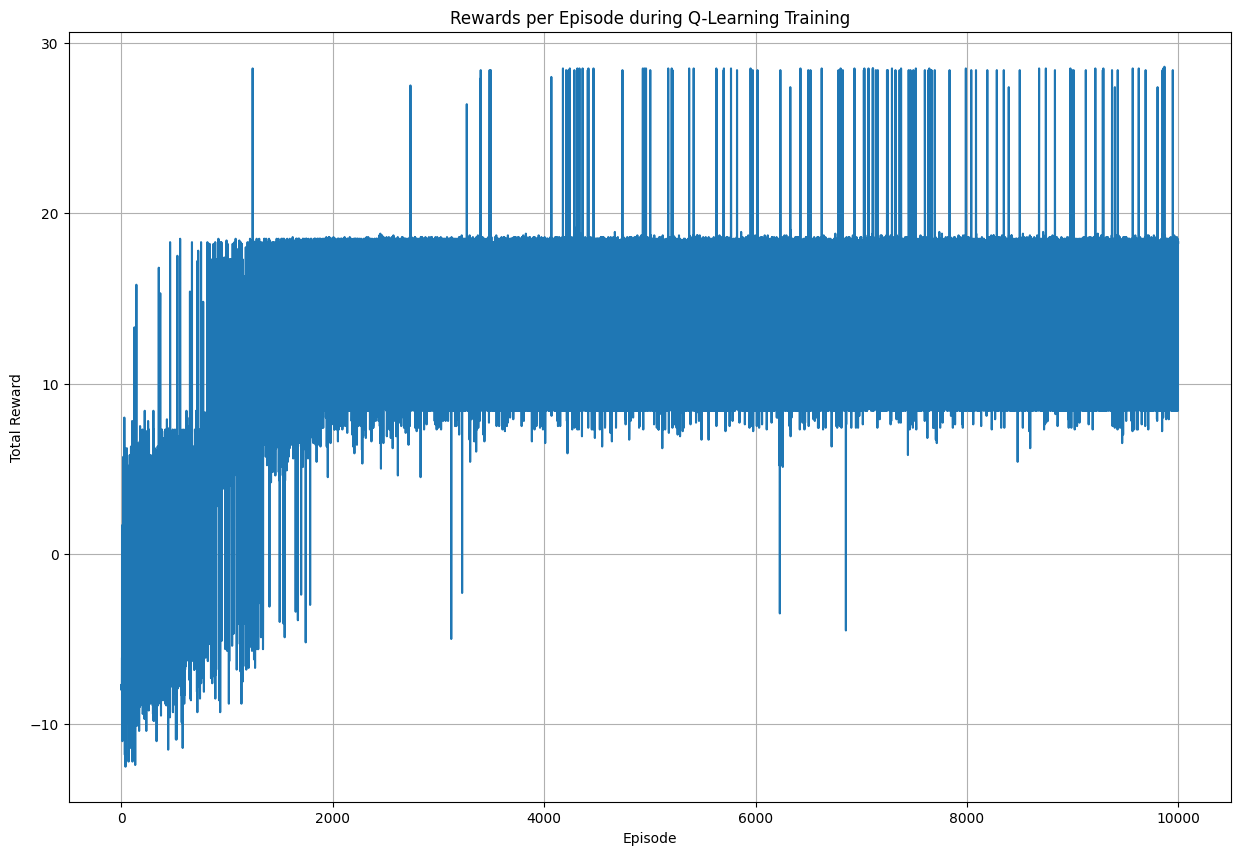


--- Testing Trained Agent (Epsilon = 0) ---

--- Test Episode 1 ---
Test Episode 1 Total Reward: 18.4

--- Test Episode 2 ---
Test Episode 2 Total Reward: 18.4

--- Test Episode 3 ---
Test Episode 3 Total Reward: 18.2

--- Test Episode 4 ---
Test Episode 4 Total Reward: 18.4

--- Test Episode 5 ---
Test Episode 5 Total Reward: 18.299999999999997

--- Test Episode 6 ---
Test Episode 6 Total Reward: 18.4

--- Test Episode 7 ---
Test Episode 7 Total Reward: 18.299999999999997

--- Test Episode 8 ---
Test Episode 8 Total Reward: 18.2

--- Test Episode 9 ---
Test Episode 9 Total Reward: 18.4

--- Test Episode 10 ---
Test Episode 10 Total Reward: 18.299999999999997

Average Test Reward over 10 episodes: 18.33


In [ ]:
if __name__ == "__main__":
  env = TicketToRideEnv()
  observation_space_size = env.observation_space.shape
  action_space_size = env.action_space.n

  # Q-Learning Agent hyperparameters
  learning_rate = 0.1
  discount_factor = 0.99
  epsilon = 1.0          # Start with full exploration
  epsilon_decay_rate = 0.0005 # Decay rate per episode
  min_epsilon = 0.01     # Minimum exploration rate

  agent = QLearningAgent(
        observation_space_size=observation_space_size,
        action_space_size=action_space_size,
        learning_rate=learning_rate,
        discount_factor=discount_factor,
        epsilon=epsilon,
        epsilon_decay_rate=epsilon_decay_rate,
        min_epsilon=min_epsilon
    )

  num_episodes = 10000 # Number of episodes to train for
  rewards_per_episode = []

  print("--- Starting Q-Learning Training ---")

  for episode in range(num_episodes):

    observation, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    env.current_episode = episode + 1

    while not terminated and not truncated:
      # agent selects action
      action = agent.select_action(observation)
      #enivorment updates, ai and palyer play the turn
      new_observation, reward, terminated, truncated, info = env.step(action)
      #learn
      agent.learn(observation, action, reward, new_observation, terminated)
      total_reward += reward
      observation = new_observation

    # After each episode:
    agent.decay_epsilon() # Decay epsilon
    rewards_per_episode.append(total_reward)

    if (episode + 1) % 500 == 0:
      avg_reward = np.mean(rewards_per_episode[-500:])
      #print(f"Episode {episode + 1}/{num_episodes}, Avg Reward (last 500): {avg_reward:.2f}, Epsilon: {agent.epsilon:.2f}\n")

# ------------------CODE FOR ANIMATING DEMONSTRATION AGENT AFTER EACH 500 EPISODES TO SEE BEHAVIOR----------------------
#      demo_epsilon = agent.epsilon # Store current epsilon
#      agent.epsilon = 0.0 # Temporarily set epsilon to 0 for deterministic demo
#
#      demo_observation, demo_info = env.reset()
#      demo_terminated = False
#      demo_truncated = False
#      demo_total_reward = 0
#      demo_step = 0
#
#      while not demo_terminated and not demo_truncated:
#        #print("__________________new Turn_________________")
#        clear_output(wait=True)
#        display(env.figure)
#        env.current_episode = f"Demo {episode + 1}" # Update episode label for demo
#
#        env.current_step = demo_step # Update step for demo
#        env.render() # Render each step of the demo
#
#        demo_action = agent.select_action(demo_observation)
#        demo_new_observation, demo_reward, demo_terminated, demo_truncated, demo_info = env.step(demo_action)
#
#        demo_total_reward += demo_reward
#        demo_observation = demo_new_observation
#        demo_step += 1
#
#        if demo_terminated or demo_truncated:
#          clear_output(wait=True) # Clear output for the final frame
#          display(env.figure)
#          env.current_episode = f"Demo {episode + 1}" # Final render for demo
#          env.current_step = demo_step
#          env.render()
#          break
#
#      agent.epsilon = demo_epsilon # Restore original epsilon
#      print(f"--- End of demonstration episode. Total Reward: {demo_total_reward:.2f} ---\n")



# ----------------------------------After training is finished, plot reward per episode to see model progression---------------------------
  print("\n--- Training Finished ---")
  # Plotting the rewards
  plt.figure(figsize=(15, 10))
  plt.plot(rewards_per_episode)
  plt.title('Rewards per Episode during Q-Learning Training')
  plt.xlabel('Episode')
  plt.ylabel('Total Reward')
  plt.grid(True)
  plt.show()


# -----------------------Run a number of test games, print the total reward and average reward to see how the model is performing in single games----------------------------
  print("\n--- Testing Trained Agent (Epsilon = 0) ---")
  agent.epsilon = 0.0 # Set epsilon to 0 for pure exploitation
  test_rewards = []
  num_test_episodes = 10


  for i in range(num_test_episodes):
    observation, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    print(f"\n--- Test Episode {i+1} ---")
    while not terminated and not truncated:
      action = agent.select_action(observation)
      observation, reward, terminated, truncated, info = env.step(action)
      total_reward += reward
      #env.render() # Render each step during testing
      if terminated or truncated:
        break
    test_rewards.append(total_reward)
    print(f"Test Episode {i+1} Total Reward: {total_reward}")

  print(f"\nAverage Test Reward over {num_test_episodes} episodes: {np.mean(test_rewards):.2f}")

